# Tutorial for COMP7606 Assignment 1

In this tutorial, I will show you how to
- train a baseline model for cat pose estimation

This tutorial only contains some basic usage of MMPose. 
Please learn more about MMPose at https://mmpose.readthedocs.io/en/latest/.

Let's start!

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/userhome/35/sjin/anaconda3/envs/open-mmlab/bin/python


In [2]:
# install pytorch
!pip install torch

# install mmcv-full. Please follow the instruction (https://github.com/open-mmlab/mmcv) to install mmcv-full.
!pip install mmcv-full==1.3.18 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html

# install mmdet for inference demo
!pip install mmdet

# clone mmpose repo
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git

# clone necessary files for this assignment
!rm -rf COMP7606
!git clone https://github.com/jin-s13/COMP7606.git

%cd mmpose

# install mmpose dependencies
!pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Cloning into 'mmpose'...
remote: Enumerating objects: 15123, done.
remote: Counting objects: 100% (1099/1099), done.
remote: Compressing objects: 100% (565/565), done.
remote: Total 15123 (delta 642), reused 839 (delta 516), pack-reused 14024
Receiving objects: 100% (15123/15123), 22.95 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (10456/10456), done.
Checking out files: 100% (1400/1400), done.
Cloning into 'COMP7606'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 6), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (25/25), done.
/userhome/35/sjin/WORK/mmpose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/.sjin/pip-install-epm43hon/poseval_ebeb07f0e93c4b0a83de19998e947e19
  Run

In [3]:
# Check Pytorch installation
import torch, torchvision
print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose
print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.10.0+cu102 True
torchvision version: 0.11.1+cu102
mmpose version: 0.21.0
cuda version: 10.2
compiler information: GCC 7.3


In [4]:
!pip install tensorboard tensorboardX

  Using cached importlib_metadata-4.8.2-py3-none-any.whl (17 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.8.2 which is incompatible.


## Train a cat pose estimation model 

To train a cat pose estimation model on a customized dataset with MMPose, there are usually three steps:
1. Support the dataset in MMPose
1. Create a config
1. Perform training and evaluation

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the [document](https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the dataset, which contains 1328 images (1000 for training, 128 for validation and 200 for testing).

In [5]:
# download dataset
%mkdir data
%mkdir data/cats
%cp ../COMP7606/Cats.tar data/cats
%cd data/cats
!tar -xf Cats.tar
%cd ../../

/userhome/35/sjin/WORK/mmpose/data/cats
/userhome/35/sjin/WORK/mmpose


In [6]:
# The <_base_/cats.py> contains the dataset information, i.e. the keypoint definition, flip pairs, and sigmas for evaluation.
!cp ../COMP7606/configs/_base_/cats.py configs/_base_/datasets/ 
# The <configs/cats/res50_cats_128x128.py> is a baseline config file. You can use this to train/evaluate the model. 
# But the performance of the baseline model is not good enough. You should try to improve it!
!cp -r ../COMP7606/configs/cats configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ 

After downloading the data, we implement a new dataset class to load data samples for model training and validation. In this assignment, we are going to train a top-down pose estimation model (refer to [Top-down Pose Estimation](https://github.com/open-mmlab/mmpose/tree/master/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap#readme) for a brief introduction), the new dataset class inherits `AnimalAP10KDataset`.

In [7]:
import json
import os
import os.path as osp
from collections import OrderedDict

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.animal import AnimalAP10KDataset


@DATASETS.register_module()
class AnimalCatsDataset(AnimalAP10KDataset):

	def __init__(self,
				 ann_file,
				 img_prefix,
				 data_cfg,
				 pipeline,
				 dataset_info=None,
				 test_mode=False):
		super().__init__(
			ann_file, img_prefix, data_cfg, pipeline, dataset_info, test_mode=test_mode)

### Create a training config file

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Learn about Configs](https://mmpose.readthedocs.io/en/latest/tutorials/0_config.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a ResNet on COCO dataset, and modify it to adapt to the Cats dataset.

Note that the following config file is just an example to show how to train a model. 
This config file is far from optimal and the baseline model is not good enough. You should try your best to improve it. 

In [8]:
from mmcv import Config
cfg = Config.fromfile(
    './configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
)

# set basic configs
cfg.data_root = 'data/cats'
cfg.work_dir = 'work_dirs/res50_cats_128x128'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 5

# set batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)


# set dataset configs
cfg.data.train.type = 'AnimalCatsDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/annotations/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'AnimalCatsDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/annotations/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'AnimalCatsDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/annotations/test_info.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)


dataset_info = dict(
    dataset_name='cats',
    paper_info=dict(
        title='Assignment for COMP7606',
        year='2022',
        homepage='https://github.com/jin-s13/COMP7606'),
    keypoint_info=dict({
        0:
        dict(
            name='L_Eye', id=0, color=[0, 255, 0], type='upper', swap='R_Eye'),
        1:
        dict(
            name='R_Eye',
            id=1,
            color=[255, 128, 0],
            type='upper',
            swap='L_Eye'),
        2:
        dict(name='Nose', id=2, color=[51, 153, 255], type='upper', swap=''),
        3:
        dict(name='Neck', id=3, color=[51, 153, 255], type='upper', swap=''),
        4:
        dict(
            name='Root of tail',
            id=4,
            color=[51, 153, 255],
            type='lower',
            swap=''),
        5:
        dict(
            name='L_Shoulder',
            id=5,
            color=[51, 153, 255],
            type='upper',
            swap='R_Shoulder'),
        6:
        dict(
  

### Train and Evaluation

In [9]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 1000
=> load 1104 samples
load checkpoint from torchvision path: torchvision://resnet50


The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-12-09 00:33:13,960 - mmpose - INFO - Start running, host: sjin@gpu-comp-105, work_dir: /userhome/35/sjin/WORK/mmpose/work_dirs/res50_cats_128x128
2021-12-09 00:33:13,965 - mmpose - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook          

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 124
=> load 132 samples


2021-12-09 00:33:17,740 - mmpose - INFO - Epoch [1][1/69]	lr: 1.000e-08, eta: 1:15:38, time: 3.291, data_time: 2.623, memory: 1714, mse_loss: 0.0016, acc_pose: 0.0225, loss: 0.0016
2021-12-09 00:33:18,482 - mmpose - INFO - Epoch [1][2/69]	lr: 1.009e-06, eta: 0:46:19, time: 0.743, data_time: 0.100, memory: 2108, mse_loss: 0.0015, acc_pose: 0.0118, loss: 0.0015
2021-12-09 00:33:19,216 - mmpose - INFO - Epoch [1][3/69]	lr: 2.008e-06, eta: 0:36:28, time: 0.735, data_time: 0.094, memory: 2108, mse_loss: 0.0012, acc_pose: 0.0000, loss: 0.0012
2021-12-09 00:33:19,948 - mmpose - INFO - Epoch [1][4/69]	lr: 3.007e-06, eta: 0:31:31, time: 0.732, data_time: 0.093, memory: 2108, mse_loss: 0.0016, acc_pose: 0.0074, loss: 0.0016
2021-12-09 00:33:20,673 - mmpose - INFO - Epoch [1][5/69]	lr: 4.006e-06, eta: 0:28:31, time: 0.725, data_time: 0.095, memory: 2108, mse_loss: 0.0016, acc_pose: 0.0144, loss: 0.0016
2021-12-09 00:33:21,408 - mmpose - INFO - Epoch [1][6/69]	lr: 5.005e-06, eta: 0:26:34, time: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 97.4 task/s, elapsed: 1s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.124
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.394
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2021-12-09 00:35:00,528 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_5.pth.
2021-12-09 00:35:00,530 - mmpose - INFO - Best AP is 0.0836 at 5 epoch.
2021-12-09 00:35:00,533 - mmpose - INFO - Epoch(val) [5][9]	AP: 0.0836, AP .5: 0.3250, AP .75: 0.0090, AP (M): 0.0258, AP (L): 0.0812, AR: 0.1242, AR .5: 0.3939, AR .75: 0.0379, AR (M): 0.2200, AR (L): 0.1206
2021-12-09 00:35:03,192 - mmpose - INFO - Epoch [6][1/69]	lr: 1.000e-05, eta: 0:04:45, time: 2.647, data_time: 2.524, memory: 2108, mse_loss: 0.0014, acc_pose: 0.1627, loss: 0.0014
2021-12-09 00:35:03,335 - mmpose - INFO - Epoch [6][2/69]	lr: 1.000e-05, eta: 0:04:44, time: 0.146, data_time: 0.018, memory: 2108, mse_loss: 0.0012, acc_pose: 0.2812, loss: 0.0012
2021-12-09 00:35:03,445 - mmpose - INFO - Epoch [6][3/69]	lr: 1.000e-05, eta: 0:04:43, time: 0.108, data_time: 0.007, memory: 2108, mse_loss: 0.0013, acc_pose: 0.1658, loss: 0.0013
2021-12-09 00:35:03,565 - mmpose - INFO - Epoch [6][4/69]	lr: 1.000e-05, eta: 0:0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 99.6 task/s, elapsed: 1s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...


2021-12-09 00:36:02,349 - mmpose - INFO - The previous best checkpoint /userhome/35/sjin/WORK/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_5.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.412
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.210
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.508
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.204


2021-12-09 00:36:04,076 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2021-12-09 00:36:04,078 - mmpose - INFO - Best AP is 0.1308 at 10 epoch.
2021-12-09 00:36:04,080 - mmpose - INFO - Epoch(val) [10][9]	AP: 0.1308, AP .5: 0.4116, AP .75: 0.0528, AP (M): 0.0406, AP (L): 0.1257, AR: 0.2098, AR .5: 0.5076, AR .75: 0.1515, AR (M): 0.3600, AR (L): 0.2040
2021-12-09 00:36:06,724 - mmpose - INFO - Epoch [11][1/69]	lr: 1.000e-06, eta: 0:02:25, time: 2.629, data_time: 2.510, memory: 2108, mse_loss: 0.0012, acc_pose: 0.4283, loss: 0.0012
2021-12-09 00:36:06,890 - mmpose - INFO - Epoch [11][2/69]	lr: 1.000e-06, eta: 0:02:25, time: 0.167, data_time: 0.013, memory: 2108, mse_loss: 0.0009, acc_pose: 0.2591, loss: 0.0009
2021-12-09 00:36:07,014 - mmpose - INFO - Epoch [11][3/69]	lr: 1.000e-06, eta: 0:02:25, time: 0.124, data_time: 0.005, memory: 2108, mse_loss: 0.0013, acc_pose: 0.3260, loss: 0.0013
2021-12-09 00:36:07,118 - mmpose - INFO - Epoch [11][4/69]	lr: 1.000e-06, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 97.2 task/s, elapsed: 1s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...


2021-12-09 00:37:05,523 - mmpose - INFO - The previous best checkpoint /userhome/35/sjin/WORK/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_10.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.428
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.226
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.538
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.220


2021-12-09 00:37:07,191 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_15.pth.
2021-12-09 00:37:07,193 - mmpose - INFO - Best AP is 0.1374 at 15 epoch.
2021-12-09 00:37:07,194 - mmpose - INFO - Epoch(val) [15][9]	AP: 0.1374, AP .5: 0.4278, AP .75: 0.0600, AP (M): 0.0429, AP (L): 0.1323, AR: 0.2258, AR .5: 0.5379, AR .75: 0.1667, AR (M): 0.3800, AR (L): 0.2198
2021-12-09 00:37:09,846 - mmpose - INFO - Epoch [16][1/69]	lr: 1.000e-07, eta: 0:01:05, time: 2.636, data_time: 2.507, memory: 2108, mse_loss: 0.0012, acc_pose: 0.3103, loss: 0.0012
2021-12-09 00:37:09,952 - mmpose - INFO - Epoch [16][2/69]	lr: 1.000e-07, eta: 0:01:05, time: 0.105, data_time: 0.012, memory: 2108, mse_loss: 0.0012, acc_pose: 0.3421, loss: 0.0012
2021-12-09 00:37:10,072 - mmpose - INFO - Epoch [16][3/69]	lr: 1.000e-07, eta: 0:01:04, time: 0.121, data_time: 0.013, memory: 2108, mse_loss: 0.0009, acc_pose: 0.3398, loss: 0.0009
2021-12-09 00:37:10,189 - mmpose - INFO - Epoch [16][4/69]	lr: 1.000e-07, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 101.3 task/s, elapsed: 1s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.07s).
Accumulating evaluation results...


2021-12-09 00:38:08,320 - mmpose - INFO - The previous best checkpoint /userhome/35/sjin/WORK/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_15.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.459
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.231
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.545
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.225


2021-12-09 00:38:09,996 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2021-12-09 00:38:09,997 - mmpose - INFO - Best AP is 0.1437 at 20 epoch.
2021-12-09 00:38:09,999 - mmpose - INFO - Epoch(val) [20][9]	AP: 0.1437, AP .5: 0.4588, AP .75: 0.0724, AP (M): 0.0472, AP (L): 0.1375, AR: 0.2311, AR .5: 0.5455, AR .75: 0.1818, AR (M): 0.3800, AR (L): 0.2246


As shown above, the performance of the validation set is reported every 5 epochs. We observe that after 20 epochs, the model achieves 0.153 mAP (AP@0.5:0.95). 
Please train the model on the training set and evaluate the model performance locally on the validation set. 

The logs/models can be found in work_dir: "$MMPOSE/work_dirs/res50_cats_128x128"

### Visualize
Here we show how to inference and visualize a model checkpoint. 

load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


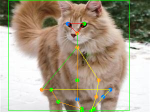

In [10]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False
from xtcocotools.coco import COCO
from mmcv import Config
from mmpose.datasets import DatasetInfo
import cv2

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True


# initialize pose model
pose_config = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
pose_checkpoint = 'work_dirs/res50_cats_128x128/latest.pth'
# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)

# Use coco api to read the validation set 
coco = COCO('data/cats/annotations/val.json')
img_keys = list(coco.imgs.keys())
image_id =  img_keys[-1]
image = coco.loadImgs(image_id)[0]
image_name = os.path.join('data/cats/images', image['file_name'])
ann_ids = coco.getAnnIds(image_id)

config = Config.fromfile(
    './configs/_base_/datasets/cats.py'
)
dataset = pose_model.cfg.data['test']['type']
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
if dataset_info is None:
    warnings.warn(
        'Please set `dataset_info` in the config.'
        'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
        DeprecationWarning)
else:
    dataset_info = DatasetInfo(dataset_info)


# make bounding boxes
box_results = []
for ann_id in ann_ids:
    item = {}
    ann = coco.anns[ann_id]
    # bbox format is 'xywh'
    item['bbox'] = ann['bbox']
    box_results.append(item)

# test a single image, with a list of bboxes
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    image_name,
    box_results,
    bbox_thr=None,
    format='xywh',
    dataset='AnimalCatsDataset',
    dataset_info=dataset_info)


# show pose estimation results
vis_result = vis_pose_result(pose_model,
                             image_name,
                             pose_results,
                             kpt_score_thr=0.,
                             dataset='AnimalCatsDataset',
                             show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
  from IPython.display import Image, display
  import tempfile
  import os.path as osp
  import cv2
  with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    display(Image(file_name))
else:
  cv2_imshow(vis_result)

### Test

In [11]:
from mmpose.datasets import build_dataset, build_dataloader
from mmpose.models import build_posenet
from mmpose.apis import single_gpu_test
from mmcv.parallel import MMDataParallel
from mmcv.runner import load_checkpoint
import os
import mmcv

# build dataset
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
test_loader_cfg = {**dict(shuffle=False, drop_last=False), 
              **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
              **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
              **cfg.data.get('test_dataloader', {})
             }
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build model
model = build_posenet(cfg.model)
model = MMDataParallel(model, device_ids=[0])
load_checkpoint(model, os.path.join(cfg.work_dir, "latest.pth"), map_location='cpu')

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
outputs = single_gpu_test(model, data_loader)
dataset.evaluate(outputs, cfg.work_dir)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 200
=> load 223 samples
load checkpoint from torchvision path: torchvision://resnet50


The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 110.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDet

OrderedDict([('AP', 0.0),
             ('AP .5', 0.0),
             ('AP .75', 0.0),
             ('AP (M)', 0.0),
             ('AP (L)', 0.0),
             ('AR', 0.0),
             ('AR .5', 0.0),
             ('AR .75', 0.0),
             ('AR (M)', 0.0),
             ('AR (L)', 0.0)])

Please simply ignore the evaluation results (0.000). It means nothing. Since the provided "test_info.json" does not contain any ground-truth keypoint annotations, so you cannot evaluate it locally. But you can obtain the "result_keypoints.json" under the work_dir.

### For submission

Finally, you should submit the training config file, model checkpoint, the training logs. They can be found in the work_dir.
TA will running model inference on the test set, and use the mAP of the test set for final performance ranking.

In the following, I will show how to prepare the files for submission.

In [12]:
%cd ..
# change "123456" to your student ID
%mkdir 123456
%cd 123456
%mkdir models
%cp ../mmpose/work_dirs/res50_cats_128x128/latest.pth ./models/model.pth # model checkpoint (choose the model you like.)
%cp ../mmpose/work_dirs/res50_cats_128x128/None.log.json ./models/ # training log
%cp ../mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py ./models/ # config file 
%cp ../mmpose/work_dirs/res50_cats_128x128/result_keypoints.json ./
# You also need to prepare the final report.pdf


# You also need to upload the codes and a simple README.txt describing which files are changed.
# NOTICE! Do NOT upload the dataset and the work_dirs. They are too large.

/userhome/35/sjin/WORK
/userhome/35/sjin/WORK/123456
